## Objective 2

In this notebook we tackle the second of the problems outlined in this analysis, investigate supervised machine learning tasks for predicting the genre of video games. The dataset includes games which are drawn from 12 different genres, this asks the question whether or not we can predict the genre of a video game given its sales and release date? To answer this question we fit and evaluate two types of model: decision tree and k-nearest neighbours (KNN). We will construct feature vectors containing only the numeric variables in the data set ("Year", "NA_Sales", "EU_Sales", "JP_Sales" and "Other_Sales") as categorical variables would require a special encoding e.g. one-hot encoding. This would increase the dimensionality of our feature vectors and therefore the risk of overfitting our models drastically increases. We will evaluate the two different machine learning (ML) models for this task using the implementations available in Scikit Learn.

### Decision Trees
We begin by implementing a decision tree model for classification across all 12 genres of games in the dataset. The first implementation will use the default decision tree class from Scikit Learn. As we are performing a classification task we need to encode our variables as integers in order to train our model, henceforth we will assign a value from 0 to 11 for each genre. Also, we will split our data into $\frac{2}{3}$ training data and $\frac{1}{3}$ test data. This way we can measure the accuracy of our model on held out data to give an indication of how well the model generalises to unseen data.

In [3]:
# Imports
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
import sys
import pickle as pk

sys.path.append("..")
from src.utility import plot_params

In [2]:
# Read the data
data = pd.read_csv("../data/processed/vgsales_processed.csv")

In [4]:
# Look at numerical variables only and genre
data_numeric_vars = data[["Year", "NA_Sales", "EU_Sales", "JP_Sales", "Other_Sales", "Genre"]]
X = data_numeric_vars[["Year", "NA_Sales", "EU_Sales", "JP_Sales", "Other_Sales" ]].to_numpy()

# Create dictionary to encode the target variables as real numbers
encoding = {"Sports" : 0, "Platform" : 1, "Racing" : 2, "Role-Playing" : 3, "Puzzle" : 4, "Misc" : 5,
            "Shooter" : 6, "Simulation" : 7, "Action" : 8, "Fighting" : 9, "Adventure" : 10, "Strategy" : 11}
y = data_numeric_vars["Genre"].map(encoding).to_numpy()

# Split into 2/3 train and 1/3 test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=5) 

# Initialise and fit a decision tree classifier
DTree = tree.DecisionTreeClassifier(random_state=0)
numeric_vars_tree_model = DTree.fit(X_train, y_train)

# Save the model
with open("../models/numeric_vars_tree_model.pkl", "wb") as file:
    pk.dump(numeric_vars_tree_model, file)

# Make predictions and calculate accuracy
print("Decision tree with all numeric variables:")
print("Accuracy of decision tree is: {}".format(numeric_vars_tree_model.score(X_test, y_test)))

Decision tree with all numeric variables:
Accuracy of decision tree is: 0.19587440671778023


The accuracy measured for this model on the test set is approximately 19.6%. This is reasonably low, however if we were to assign a datapoint to a class at random we would expect to guess correctly 1 in every 12, which is roughly 8.3%. When compared to this figure our model doesn't seem to perform all that badly. Now we investigate how removing the "Year" variable affects the accuracy of the model. As we had to impute the year of release for a number of datapoints this could be negatively impacting the model, therefore it would be good to check if we are able to improve our model by removing it from our feature vectors and only using the sales data. 

In [9]:
# Drop the year variable and reimplement Decsion Tree
X_train_sales, X_test_sales = X_train[:,1:], X_test[:,1:]
sales_tree_model = DTree.fit(X_train_sales, y_train)
y_pred_sales = sales_tree_model.predict(X_test_sales)

# Save the model
with open("../models/sales_tree_model.pkl", "wb") as file:
    pk.dump(sales_tree_model, file)

print("Decision tree with only sales data:")
print("Accuracy of decision tree with only sales data is: {}".format(sales_tree_model.score(X_test_sales, y_test)))

Decision tree with only sales data:
Accuracy of decision tree with only sales data is: 0.1927710843373494


The new accuracy of the decision tree model is approximately 19.3%. This is a very minor drop in accuracy and does not tell us anything definitive about whether it is useful to include the year of release as a feature or not. Due to this result we will carry on to consider the year of release as a feature in the models to come.

### K-Nearest Neighbours

We now compare our decision tree model with another ML technique, $k$-nearest neighbours (KNN). KNN exploits the arrangement of data in space and makes the assumption that datapoints close to each other are often similar (which is frequently a sensible assumption). For a given test datapoint the closest $k$ neighbours are found in the training set. Following this the test point is assigned a class, which is determined by the majority vote of its neighbours. This means the class assigned is the class that the majority of its $k$ neighbours belong to. Sometimes there may be no majority vote and there is a tie amongst the $k$ neighbours. In such cases there are several methods of breaking a tie - including examining the class of the next nearest point.

When calculating the distance between points a number of different metrics can be used. For our purposes we will use the Euclidean distance between points. For this reason it is beneficial to normalise the data before training the model. This involves rescaling the data so that every point falls in the range [0, 1] by applying the formula

$$\vec{x}_{\textrm{norm}} = \frac{\vec{x} - \min(\vec{x})}{\max(\vec{x}) - \min(\vec{x})}, $$

to each datapoint. This is performed elementwise for all entries in the vector $\vec{x}$. The reason for rescaling the data is so that all features have the same relative impact on the model. If a certain feature had a greater range of values then the feature would contribute considerably more to the total Euclidean distance between this datapoint and another. This feature would then be dominant over the others when implementing the model, but we would like each of our features to contribute to the model on the same relative scale. To achieve this we can use a default method of normalising the data available in the Scikit Learn package.

We now fit a KNN model for 12 class classification using only the numeric variables from our dataset. As we do not yet know which value of $k$ will yield the most accurate model we will evaluate models each with a different value from 1 to 100. We shall compute the accuracy on the test set for each of these models and then select the value of $k$ that achieves the greatest accuracy as the parameter for our final KNN model. The train and test splits we are using here are the same as those for the decision tree models, this allows a more accurate comparison of the two models.

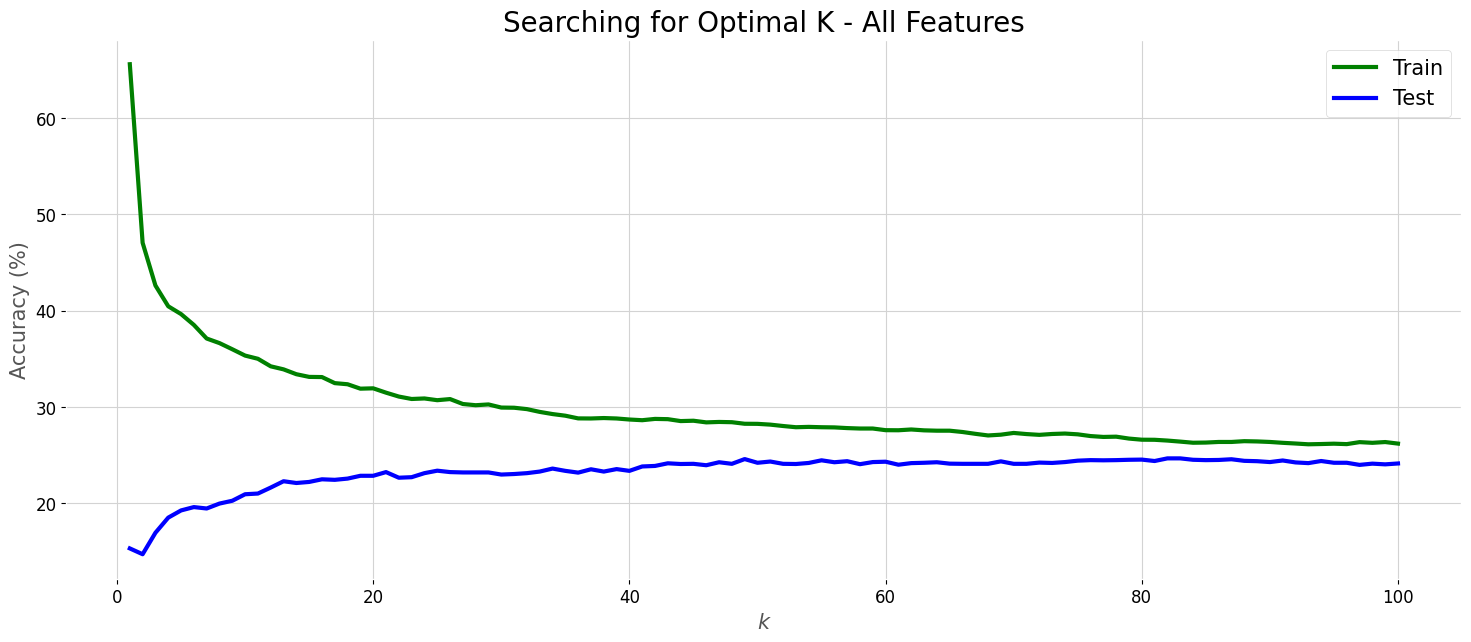

KNN with all numeric variables as features:
Best accuracy on the test set is: 0.24680540343190946, achieved when k = 82


In [12]:
# Normalise data
normaliser = MinMaxScaler()
X_train_scaled = normaliser.fit_transform(X_train)
X_test_scaled = normaliser.fit_transform(X_test)

# KNN model
num_k_values = 100
k_values = np.arange(1, num_k_values + 1)
train_accuracies = np.zeros(num_k_values)
test_accuracies = np.zeros(num_k_values)
for k in k_values:
    KNN = KNeighborsClassifier(n_neighbors=k)
    KNN.fit(X_train_scaled, y_train)
    train_accuracies[k - 1] = KNN.score(X_train_scaled, y_train)
    test_accuracies[k - 1] = KNN.score(X_test_scaled, y_test)
    
# Plot train and test accuracies
plt.figure(figsize=(18,7))
plt.plot(k_values, train_accuracies * 100, label="Train", color = 'g', lw=3)
plt.plot(k_values, test_accuracies * 100, label ="Test", color = 'b', lw=3)
plt.legend(fontsize=15)
plt.title("Searching for Optimal K - All Features", fontsize=20)
plt.ylabel("Accuracy (%)", fontsize=15)
plt.xlabel(r"$k$", fontsize=15)
# plt.savefig("../reports/figures/Searching for Optimal K - All Features.png")
plt.show()  
  
# Find best k
index = np.argmax(test_accuracies)
best_k = index + 1
best_accuracy = test_accuracies[index]

# Re-train KNN model with the best accuracy
numeric_vars_KNN_best_k = KNeighborsClassifier(n_neighbors=best_k)
numeric_vars_KNN_best_k.fit(X_train_scaled, y_train)

# Save the model
with open("../models/numeric_vars_KNN_best_k.pkl", "wb") as file:
    pk.dump(numeric_vars_KNN_best_k, file)

print("KNN with all numeric variables as features:")
print("Best accuracy on the test set is: {}, achieved when k = {}".format(best_accuracy, best_k))

Plotted above is the accuracy of the model on the training and test set for each value of k. We see that for small values of k the accuracy on the training set is high, on the contrary the accuracy on the test set is very low. This tells us that we are drastically overfitting the training data for these low values of k. As k increases we find that the training accuracy decreases and the test accuracy begins to slowly increase. The two values for accuracy begin to flatten and stabilise around the k=80 point. The accuracy on the training set is unimportant and we are truly interested in how well our model generalises to unseen data (i.e. the test accuracy). For this reason we conclude that the best value of k is 82 when using all numeric variables.

Now we will again remove the "Year" from our features and implement the model again.

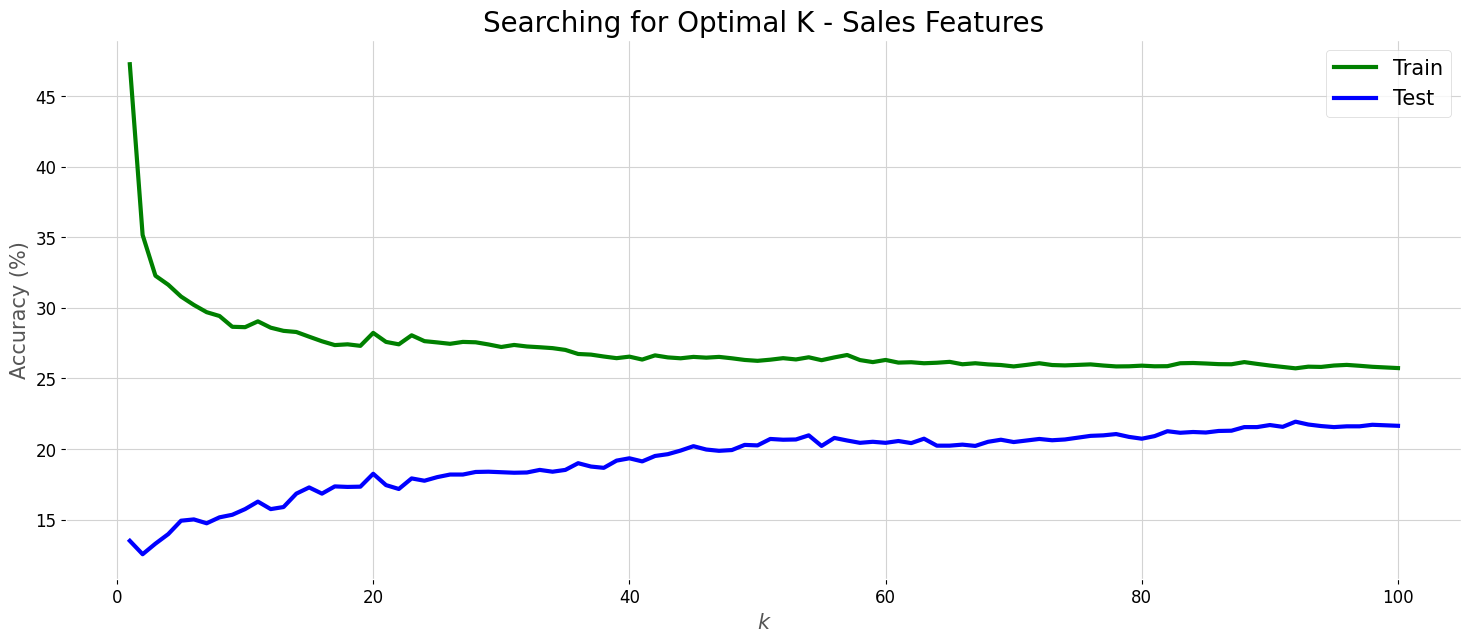

KNN with only sales data as features:
Best accuracy on the test set is: 0.2194231471339905, achieved when k = 92


In [13]:
# Normalise data
normaliser = MinMaxScaler()
X_train_scaled = normaliser.fit_transform(X_train_sales)
X_test_scaled = normaliser.fit_transform(X_test_sales)

# KNN model
num_k_values = 100
k_values = np.arange(1, num_k_values + 1)
train_accuracies = np.zeros(num_k_values)
test_accuracies = np.zeros(num_k_values)
for k in k_values:
    KNN = KNeighborsClassifier(n_neighbors=k)
    KNN.fit(X_train_scaled, y_train)
    train_accuracies[k - 1] = KNN.score(X_train_scaled, y_train)
    test_accuracies[k - 1] = KNN.score(X_test_scaled, y_test)
    
# Plot train and test accuracies
plt.figure(figsize=(18,7))
plt.plot(k_values, train_accuracies * 100, label="Train", color='g', lw=3)
plt.plot(k_values, test_accuracies * 100, label ="Test", color='b', lw=3)
plt.legend(fontsize=15)
plt.title("Searching for Optimal K - Sales Features", fontsize=20)
plt.ylabel("Accuracy (%)", fontsize=15)
plt.xlabel(r"$k$", fontsize=15)
# plt.savefig("../reports/figures/Searching for Optimal K - Sales Features.png")
plt.show()  
  
# Find best k
index = np.argmax(test_accuracies)
best_k = index + 1
best_accuracy = test_accuracies[index]

# Re-train KNN model with the best accuracy
sales_KNN_best_k = KNeighborsClassifier(n_neighbors=best_k)
sales_KNN_best_k.fit(X_train_scaled, y_train)

# Save the model
with open("../models/sales_KNN_best_k.pkl", "wb") as file:
    pk.dump(sales_KNN_best_k, file)

print("KNN with only sales data as features:")
print("Best accuracy on the test set is: {}, achieved when k = {}".format(best_accuracy, best_k))

Removing the "Year" variable for the KNN model has resulted in a lower overall test accuracy with the best accuracy comng from the value of k=92. What is interesting is the graph above suggests the test accuracy is still increasing at the point k=100. This means we could potentially implement a model that generalises better and has a higher test accuracy. However, for our purposes here, we do not really want to go beyond k=100 in order to ensure our code runs at a reasonable speed. 

We can make the conclusion that of the models tested the KNN model with all numeric variables included is the most appropriate for the classification task on this dataset. In the following section we will refine our model and use it for classification of just 4 classes in the dataset.

### Four Class Classification KNN Model

So far, the methods implemented have been somewhat naive and sub-optimal. For instance, when subdividing our data into test and train sets, we were not careful to ensure that we had equal proportions of data from each class in both sets. Furthermore, if we examine the number of datapoints belonging to each class in the dataset we see large class imbalances. This can be seen in the pie chart below.

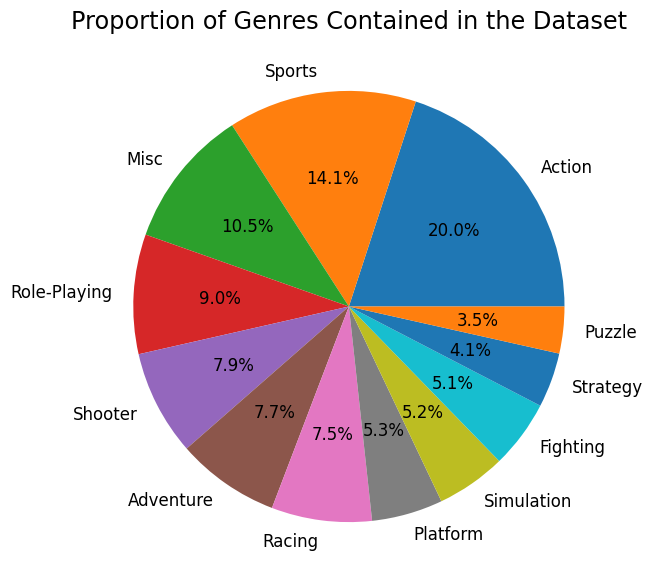

In [29]:
# Plot pie chart
data["Genre"].value_counts().plot(kind="pie", figsize=(7,7), autopct='%1.1f%%')
plt.title("Proportion of Genres Contained in the Dataset")
plt.ylabel("")
# plt.savefig("../reports/figures/Proportion of Genres Contained in the Dataset.png")
plt.show()

Ideally when training a classification model we would like an equal number of samples coming from each class. On top this, we would like as many training examples as possible. To refine our methods, wel now implement a model for classification amongst the 4 genres in the data set of which there are the most examples. Namely these genres are "Action", "Sports", "Misc" and "Role-Playing". There are the fewest datapoints of the genre "Role-Playing", therefore we shall select a random sample from each of the classes of size equal to the number of "Role-Playing" datapoints - which is 1486. The aim is to implement a more accurate model due to the fact we are only predicting one of four possible classes and we have an equal split of classes in our data.

We will then split this sample into $\frac{2}{3}$ training and $\frac{1}{3}$ test data, ensuring that an equal proportion of each class is included in both the training and test sets. The model we will be implementing is a KNN model using the "Year", "NA_Sales", "EU_Sales", "JP_Sales", and "Other_Sales" columns as features because this was the best performing model from the previous investigations. To find the optimal value of k we shall use 5-fold cross validation. This involves further subdividing the training data into five equal parts. We will then select four of the five parts of data and train the model, before validating (computing the accuracy) on the remaining part. This is then repeated for every unique combination of the subdivided training sets, i.e. select a different four parts for training and compute another validation accuracy on the new remaining set. We are essentially training five different models this way and then we report the mean cross-validation accuracy for this value of k, before repeating for every value of k. We will then choose the k value with the highest cross-validation accuracy and train a model using this value on the whole training set before reporting the accuracy on the test set.

We will also normalise the data as we did before, however to ensure we perform our cross-validation correctly we will need to be slightly more careful. The training and validation data for each iteration of cross-validation needs to be normalised before the model is trained. Clearly each combination of the four parts and single part will have different ranges of values which leads to tricky normalisation when using the default cross validation implementation from Scikit Learn. Luckily another default feature known as a "Pipeline" can be put in place and configured to ensure the normalisation is performed correctly.

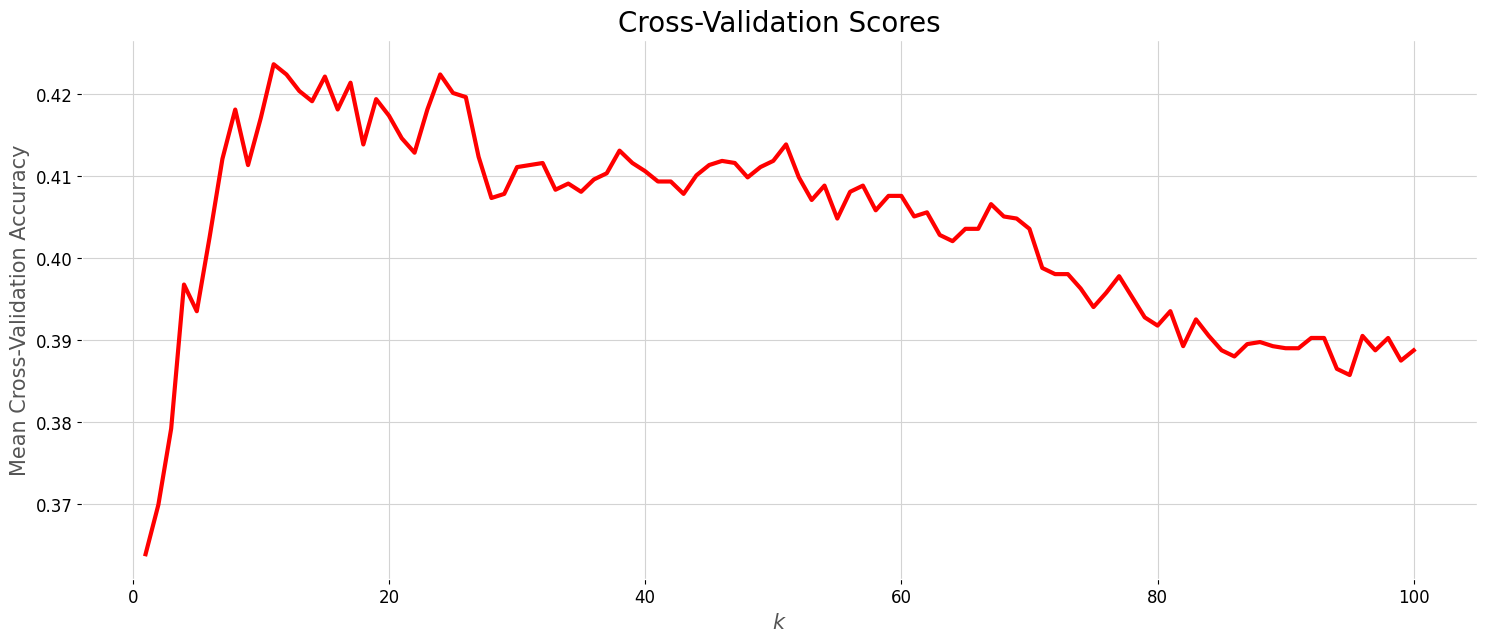

Final KNN model for 4 class classification:
Best CV score is: 0.4236161294075842 which was achieved when k = 11


In [14]:
# Produce new DataFrame containing only data from the 4 genres of interest
data_4_classes = data[(data["Genre"] == "Action") | (data["Genre"] == "Sports") | (data["Genre"] == "Misc") | (data["Genre"] == "Role-Playing")]

# Extract as many data points as possible such that there are equal numbers of each class
n_data = data_4_classes["Genre"].value_counts().min()
sample = data_4_classes.groupby("Genre").sample(n_data, random_state=1)

# Now extract just the columns we want and encode as feature vectors and labels
sample = sample[["Year", "NA_Sales", "EU_Sales", "JP_Sales", "Other_Sales", "Genre"]]
X = sample[["Year", "NA_Sales", "EU_Sales", "JP_Sales", "Other_Sales"]].to_numpy()
encoding_4_classes = {"Misc" : 0, "Role-Playing" : 1, "Action" : 2, "Sports" : 3}
y = sample["Genre"].map(encoding_4_classes).to_numpy()

# Split data into 2/3 train and 1/3 test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=5, shuffle=True, stratify=y)

# Now we want to loop through the values of k and find the cross validation score for each.
num_k_values = 100
k_values = np.arange(1, num_k_values + 1) # 1 to num_k_values
mean_cv_scores = np.zeros(num_k_values)
for k in k_values:
    KNN_4_classes = KNeighborsClassifier(n_neighbors=k)
    normaliser = MinMaxScaler()
    pipeline = Pipeline([('transformer', normaliser), ('estimator', KNN_4_classes)])
    mean_cv_scores[k - 1] = np.mean(cross_val_score(pipeline, X_train, y_train, scoring='accuracy', cv=5))

# Plot mean CV score versus k
plt.figure(figsize=(18,7))
plt.plot(k_values, mean_cv_scores, color='r', lw=3)
plt.title("Cross-Validation Scores", fontsize=20)
plt.ylabel("Mean Cross-Validation Accuracy", fontsize=15)
plt.xlabel(r"$k$", fontsize=15)
# plt.savefig("../reports/figures/Proportion of Genres Contained in the Dataset.png")
plt.show()

# Find the greatest mean CV score and the value of k
index = np.argmax(mean_cv_scores)
best_k = index + 1
best_cv_score = mean_cv_scores[index]

print("Final KNN model for 4 class classification:")
print("Best CV score is: {} which was achieved when k = {}".format(best_cv_score, best_k))

The highest mean cross-validation accuracy was approximately 42.4% which was given by the model with k=11. This is considerably higher than the previous models and if we were to guess at random (25%). We now train a model with k=11 on all of the training data before reporting the accuracy on the test set.

In [15]:
# Train model on whole training set then compute generalisation error on the test set
final_KNN = KNeighborsClassifier(n_neighbors=best_k)
normaliser = MinMaxScaler()
X_train_scaled = normaliser.fit_transform(X_train)
X_test_scaled = normaliser.fit_transform(X_test)
final_KNN.fit(X_train_scaled, y_train)

# Save the model
with open("../models/final_KNN.pkl", "wb") as file:
    pk.dump(final_KNN, file)
    
gen_error = final_KNN.score(X_test_scaled, y_test)
print("Generlisation error on test set is: {}".format(gen_error))

Generlisation error on test set is: 0.40661577608142496


For this objective, two different ML models for predicting the genre of a video game, namely decision trees and k-nearest neighbours, were considered. Furthermore, we investigated two different types of feature vector - one that contained all numeric variables in the dataset and another that used only the sales data in the table. We evaluated the ability of a few simple models to predict the genre of a video game from all of the 12 genres included in the dataset. This gave us an indication of which the most appropriate model and feature vector combination to use. Our findings suggested that the best model was a k-nearest neighbours model using all numeric variables in the dataset. Using this knowledge we refined our methodology and implemented a k-nearest neighbours model for classification amongst the genres "Sports", "Action", "Misc" and "Role-Playing" as these classes had the greatest number of datapoints in the table. Our evaluation metric was the mean cross validation accuracy using five folds. This led to us finding the value of k to be 11 which yielded an accuracy of approximately 41.0% on the test set. This was only slightly lower than the mean cross-validation accuracy for the same value of k which indicates that our model generalises to unseen data quite well. Overall the prediction accuracy is not very high, this could be due to a number of reasons. There could be issues with the data such as the sample that we took not being well representative of the whole dataset. Or there may be more underlying problems with the dataset as a whole that are not obvious at first sight. Other explanations we could offer is that simply the ML models we evaluated were not the most appropriate for the task, or the features we selected were not able to capture the essence of the data. A final point to note is the similarity of the sales of certain genres in North America to Europe. Both "Action" and "Sports" are amongst the bestselling genres in North America and Europe, therefore their sales data could be difficult to distinguish between, this could have hindered the predictive power of the model.